In [1]:
#pip install -q accelerate -U

### ***Setup***

In [2]:
import sklearn
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import evaluate
import gc
import numpy as np
from torch import nn
from transformers import Trainer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

2024-01-31 17:59:28.896715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 17:59:29.063373: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-31 17:59:29.096439: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 17:59:29.978733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline, AutoModel

checkpoint = 'seyonec/PubChem10M_SMILES_BPE_450k'
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_450k were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE_45

### ***loading data***

In [5]:
train = pd.read_csv('train_data.txt', sep='\t')
train = train.rename(columns={'Smiles String': 'Smiles', 'agg' : 'label'})

test_agg = pd.read_csv('agg_data_test.txt', sep='\t')
test_agg['label']='AGG'
test_agg.drop('ID', axis=1, inplace = True)

test_non_agg= pd.read_csv('nonagg_data_test.txt', sep='\t')
test_non_agg['label']='NONAGG'
test_non_agg.drop('ID', axis=1, inplace = True)

data = pd.concat([test_agg, test_non_agg, train], ignore_index=True)

data = data.rename(columns={'label': 'labels','Smiles' : 'smiles' })

label_map = {
    'AGG': 1,
    'NONAGG': 0,
}

data = data.drop('Unnamed: 0', axis=1 )
data['labels'] = data['labels'].map(label_map)
data.dropna(inplace=True)

In [6]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state = 42, stratify=data['labels'])
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state = 42,  stratify=train_df['labels'])

<AxesSubplot:>

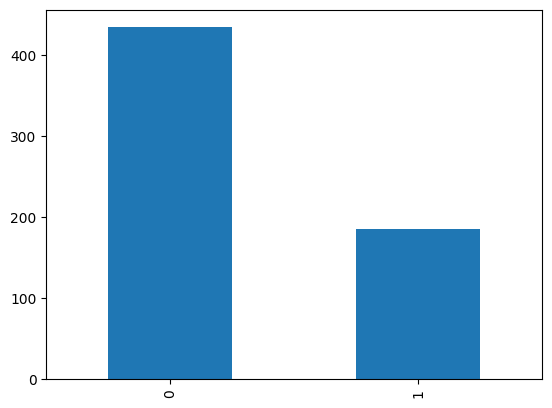

In [7]:
train_df['labels'].value_counts().plot.bar()

In [8]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Create a pipeline with both oversampling and undersampling steps
pipeline = Pipeline([
    ('over', RandomOverSampler(sampling_strategy=0.5)),  # Adjust sampling_strategy as needed
    ('under', RandomUnderSampler(sampling_strategy=1.0))  # Adjust sampling_strategy as needed
])

# Fit and apply the pipeline to the dataset
X_resampled, y_resampled = pipeline.fit_resample(train_df.drop('labels', axis=1), train_df['labels'])

# Combine the resampled features and labels into a new DataFrame
train_df = pd.DataFrame(X_resampled, columns=train_df.drop('labels', axis=1).columns)
train_df['labels'] = y_resampled

<AxesSubplot:>

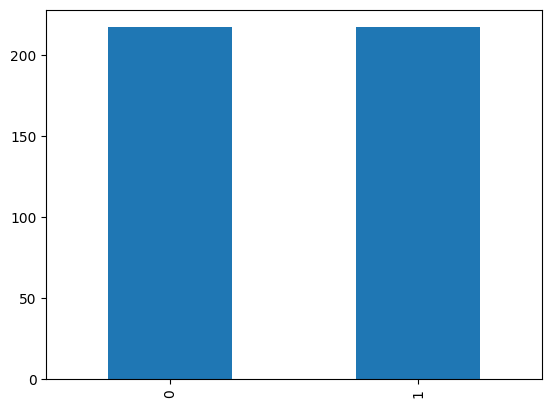

In [9]:
train_df['labels'].value_counts().plot.bar()

In [10]:
from datasets import Dataset, DatasetDict

ds_dict = {'train' : Dataset.from_pandas(train_df),
           'valid' : Dataset.from_pandas(valid_df),
           'test' : Dataset.from_pandas(test_df)}

ds = DatasetDict(ds_dict)

In [11]:
def tokenize_function(examples):

    return tokenizer(examples["smiles"])#,truncation=True)

tokenized_datasets = ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
tokenized_train=tokenized_datasets['train']
tokenized_valid=tokenized_datasets['valid']

In [13]:
from transformers import DataCollatorWithPadding

#Data collator that will dynamically pad the inputs received.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    geometric_mean = geometric_mean_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "f1": f1, "geometric_mean": geometric_mean}

In [15]:
from collections import Counter

print(dict(Counter(tokenized_train['labels'])))

{0: 217, 1: 217}


### ***Training***

In [16]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(device)
        inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.5, 0.85]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [17]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback,  IntervalStrategy

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy=IntervalStrategy.STEPS,
report_to="none", num_train_epochs=5, load_best_model_at_end=True, save_total_limit = 5,
metric_for_best_model = 'accuracy', eval_steps = 500, greater_is_better=True, learning_rate=2e-5,
lr_scheduler_type='linear')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train ,
    eval_dataset=tokenized_valid,
    compute_metrics=compute_metrics,
    data_collator= data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.000085)]
)

In [18]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=275, training_loss=0.3550935779918324, metrics={'train_runtime': 9.8307, 'train_samples_per_second': 220.737, 'train_steps_per_second': 27.974, 'total_flos': 24035071094424.0, 'train_loss': 0.3550935779918324, 'epoch': 5.0})

### ***Visualization***

In [19]:
tra_df = train_df.reset_index()
res_df = test_df.reset_index()

data = pd.concat([tra_df,res_df], axis=0)

In [20]:
from datasets import Dataset, DatasetDict

ds_dict = {'data' : Dataset.from_pandas(data)}

ds = DatasetDict(ds_dict)

In [21]:
def tokenize_function(examples):

    return tokenizer(examples["smiles"],truncation=True,padding = True, return_tensors='pt')

tokenized_datasets1 = ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [22]:
after_model=model.base_model.to(device)

In [23]:
def extract_hidden_states(batch):
 
  inputs_dict = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  
  with torch.no_grad():
    hidden = after_model(**inputs_dict).last_hidden_state
  
  return {'hidden_state':hidden[:,0].cpu().numpy()}

In [24]:
tokenized_datasets1.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [25]:
hidden = tokenized_datasets1.map(extract_hidden_states, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

## Locally Linear Embedding

<AxesSubplot:xlabel='LLE_1', ylabel='LLE_2'>

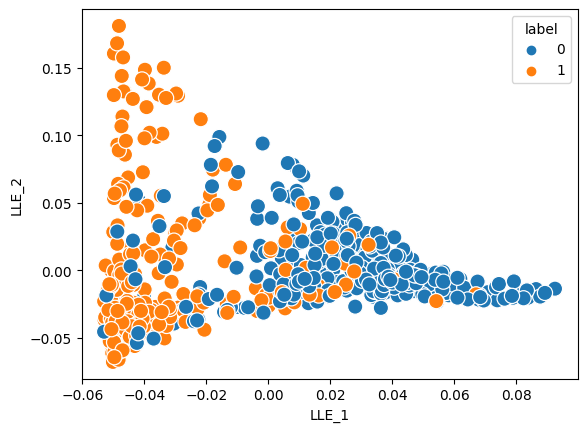

In [26]:
labels = hidden['data']['labels']

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding

scaler = StandardScaler()
hidden_state_normalized = scaler.fit_transform(hidden['data']['hidden_state'])

embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=25, method = 'standard')
transformed = embedding.fit_transform(hidden_state_normalized)

result_df = pd.DataFrame({'LLE_1': transformed[:,0], 'LLE_2': transformed[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='LLE_1', y='LLE_2', hue='label', data=result_df, ax=ax,s=120)

## Iso map

<AxesSubplot:xlabel='Isomap_1', ylabel='Isomap_2'>

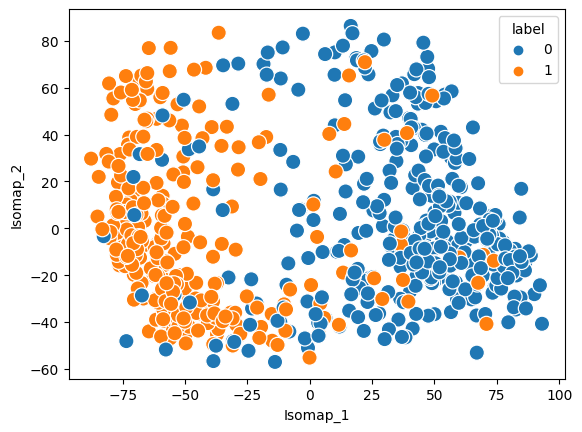

In [27]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2, n_neighbors=5, n_jobs=-1)
transformed = embedding.fit_transform(hidden['data']['hidden_state'])

result_df = pd.DataFrame({'Isomap_1': transformed[:,0], 'Isomap_2': transformed[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='Isomap_1', y='Isomap_2', hue='label', data=result_df, ax=ax,s=120)